# PredictionEnsemble Objects

One of the major features of `climpred` is our objects that are based upon the `PredictionEnsemble` class. We supply users with a `HindcastEnsemble` and `PerfectModelEnsemble` object. We encourage users to take advantage of these high-level objects, which wrap all of our core functions. These objects don't comprehensively cover all functions yet, but eventually we'll deprecate direct access to the function calls in favor of the lightweight objects.

Briefly, we consider a `HindcastEnsemble` to be one that is initialized from some observational-like product (e.g., assimilated data, reanalysis products, or a model reconstruction). Thus, this object is built around comparing the initialized ensemble to various observational products. In contrast, a `PerfectModelEnsemble` is one that is initialized off of a model control simulation. These forecasting systems are not meant to be compared directly to real-world observations. Instead, they provide a contained model environment with which to theoretically study the limits of predictability. You can read more about the terminology used in `climpred` [here](terminology.html).

Let's create a demo object to explore some of the functionality and why they are much smoother to use than direct function calls.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr

from climpred import HindcastEnsemble
from climpred.tutorial import load_dataset
import climpred

We can pull in some sample data that is packaged with `climpred`.

## HindcastEnsemble

We'll start out with a `HindcastEnsemble` demo, followed by a `PerfectModelEnsemble` case.

In [2]:
hind = climpred.tutorial.load_dataset('CESM-DP-SST') # CESM-DPLE hindcast ensemble output.
obs = climpred.tutorial.load_dataset('ERSST') # ERSST observations.
recon = climpred.tutorial.load_dataset('FOSI-SST') # Reconstruction simulation that initialized CESM-DPLE.

We need to add a "units" attribute to the hindcast ensemble so that `climpred` knows how to interpret the lead units.

In [3]:
hind["lead"].attrs["units"] = "years"

CESM-DPLE was drift-corrected prior to uploading the output, so we later need to subtract the climatology over the same period for our other products before building the object.

Now we instantiate the `HindcastEnsemble` object and append all of our products to it.

In [4]:
hindcast = HindcastEnsemble(hind) # Instantiate object by passing in our initialized ensemble.
print(hindcast)

/Users/aaron.spring/anaconda3/envs/climpred-dev/lib/python3.6/site-packages/climpred-2.0.0.post30+dirty-py3.6.egg/climpred/utils.py:141: UserWarning: Assuming annual resolution due to numeric inits. Change init to a datetime if it is another resolution.
  'Assuming annual resolution due to numeric inits. '


climpred.HindcastEnsemble

Show/Hide data repr 
 
 
 
 
 
 Show/Hide attributes 
 
 
 
 
 
 
 
 Initialized Ensemble Dimensions: init : 64 lead : 10 member : 10 Coordinates: (3) lead (lead) int32 1 2 3 4 5 6 7 8 9 10 long_name : forecast year units : years array([ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype=int32) member (member) int32 1 2 3 4 5 6 7 8 9 10 long_name : ensemble member array([ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype=int32) init (init) object 1954-01-01 00:00:00 ... 2017-01-01 00:00:00 array([cftime.DatetimeProlepticGregorian(1954-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1955-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1956-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1957-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1958-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1959-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1960-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1961-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1962-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1963-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1964-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1965-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1966-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1967-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1968-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1969-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1970-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1971-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1972-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1973-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1974-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1975-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1976-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1977-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1978-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1979-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1980-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1981-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1982-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1983-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1984-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1985-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1986-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1987-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1988-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1989-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1990-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1991-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1992-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1993-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1994-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1995-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1996-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1997-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1998-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1999-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2000-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2001-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2002-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2003-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2004-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2005-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2006-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2007-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2008-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2009-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2010-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2011-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2012-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2013-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2014-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2015-01-01 0

Now we just use the `add_` methods to attach other objects. See the API [here](api.html#add-and-retrieve-datasets). **Note that we strive to make our conventions follow those of `xarray`'s**. For example, we don't allow inplace operations. One has to run `hindcast = hindcast.add_observations(...)` to modify the object upon later calls rather than just `hindcast.add_observations(...)`.

In [5]:
hindcast = hindcast.add_observations(recon, 'reconstruction')
hindcast = hindcast.add_observations(obs, 'ERSST')
hindcast

climpred.HindcastEnsemble

Show/Hide data repr 
 
 
 
 
 
 Show/Hide attributes 
 
 
 
 
 
 
 
 Initialized Ensemble Dimensions: init : 64 lead : 10 member : 10 Coordinates: (3) lead (lead) int32 1 2 3 4 5 6 7 8 9 10 long_name : forecast year units : years array([ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype=int32) member (member) int32 1 2 3 4 5 6 7 8 9 10 long_name : ensemble member array([ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype=int32) init (init) object 1954-01-01 00:00:00 ... 2017-01-01 00:00:00 array([cftime.DatetimeProlepticGregorian(1954-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1955-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1956-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1957-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1958-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1959-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1960-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1961-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1962-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1963-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1964-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1965-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1966-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1967-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1968-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1969-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1970-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1971-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1972-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1973-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1974-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1975-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1976-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1977-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1978-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1979-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1980-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1981-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1982-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1983-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1984-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1985-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1986-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1987-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1988-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1989-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1990-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1991-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1992-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1993-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1994-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1995-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1996-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1997-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1998-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1999-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2000-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2001-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2002-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2003-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2004-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2005-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2006-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2007-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2008-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2009-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2010-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2011-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2012-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2013-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2014-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2015-01-01 0

Show/Hide data repr 
 
 
 
 
 
 Show/Hide attributes 
 
 
 
 
 
 
 
 Verification Data reconstruction Dimensions: time : 70 Coordinates: (1) time (time) object 1948-01-01 00:00:00 ... 2017-01-01 00:00:00 array([cftime.DatetimeProlepticGregorian(1948-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1949-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1950-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1951-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1952-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1953-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1954-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1955-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1956-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1957-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1958-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1959-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1960-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1961-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1962-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1963-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1964-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1965-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1966-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1967-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1968-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1969-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1970-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1971-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1972-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1973-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1974-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1975-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1976-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1977-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1978-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1979-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1980-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1981-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1982-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1983-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1984-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1985-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1986-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1987-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1988-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1989-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1990-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1991-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1992-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1993-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1994-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1995-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1996-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1997-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1998-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1999-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2000-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2001-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2002-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2003-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2004-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2005-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2006-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2007-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2008-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2009-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2010-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2011-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2012-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2013-01-01 00:00:00),
 cftime.DatetimeProlepticGre

Show/Hide data repr 
 
 
 
 
 
 Show/Hide attributes 
 
 
 
 
 
 
 
 Verification Data ERSST Dimensions: time : 61 Coordinates: (1) time (time) object 1955-01-01 00:00:00 ... 2015-01-01 00:00:00 array([cftime.DatetimeProlepticGregorian(1955-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1956-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1957-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1958-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1959-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1960-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1961-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1962-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1963-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1964-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1965-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1966-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1967-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1968-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1969-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1970-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1971-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1972-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1973-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1974-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1975-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1976-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1977-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1978-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1979-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1980-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1981-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1982-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1983-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1984-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1985-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1986-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1987-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1988-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1989-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1990-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1991-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1992-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1993-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1994-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1995-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1996-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1997-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1998-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1999-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2000-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2001-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2002-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2003-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2004-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2005-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2006-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2007-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2008-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2009-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2010-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2011-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2012-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2013-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2014-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2015-01-01 00:00:00)], dtype=object) Data variables: (1) SST (time) float32 ... array([17.788563, 17.837637, 18.004938, 18.030924, 17.984966, 17.969116,
 17.995125, 17.976297, 17.990444, 17.842377, 17.888042, 17.928734,
 17.9168 , 17.937092, 18.092508, 17.977272, 17.859001, 18.038591,
 18.042986, 17.91727 , 17.894423, 17.937723, 18.117777, 18

You can apply most standard `xarray` functions directly to our objects! `climpred` will loop through the objects and apply the function to all applicable `xarray.Datasets` within the object. If you reference a dimension that doesn't exist for the given `xarray.Dataset`, it will ignore it. This is useful, since the initialized ensemble is expected to have dimension `init`, while other products have dimension `time` (see more [here](setting-up-data.html)).

Let's start by taking the ensemble mean of the initialized ensemble so our metric computations don't have to take the extra time on that later. I'm just going to use deterministic metrics here, so we don't need the individual ensemble members. Note that above our initialized ensemble had a `member` dimension, and now it is reduced.

In [6]:
hindcast = hindcast.mean('member')
hindcast

climpred.HindcastEnsemble

Show/Hide data repr 
 
 
 
 
 
 Show/Hide attributes 
 
 
 
 
 
 
 
 Initialized Ensemble Dimensions: init : 64 lead : 10 Coordinates: (2) lead (lead) int32 1 2 3 4 5 6 7 8 9 10 long_name : forecast year units : years array([ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype=int32) init (init) object 1954-01-01 00:00:00 ... 2017-01-01 00:00:00 array([cftime.DatetimeProlepticGregorian(1954-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1955-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1956-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1957-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1958-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1959-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1960-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1961-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1962-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1963-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1964-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1965-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1966-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1967-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1968-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1969-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1970-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1971-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1972-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1973-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1974-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1975-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1976-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1977-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1978-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1979-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1980-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1981-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1982-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1983-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1984-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1985-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1986-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1987-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1988-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1989-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1990-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1991-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1992-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1993-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1994-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1995-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1996-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1997-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1998-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1999-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2000-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2001-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2002-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2003-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2004-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2005-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2006-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2007-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2008-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2009-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2010-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2011-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2012-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2013-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2014-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2015-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2016-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2017-01-01 00:00:00)], dtype=objec

Show/Hide data repr 
 
 
 
 
 
 Show/Hide attributes 
 
 
 
 
 
 
 
 Verification Data reconstruction Dimensions: time : 70 Coordinates: (1) time (time) object 1948-01-01 00:00:00 ... 2017-01-01 00:00:00 array([cftime.DatetimeProlepticGregorian(1948-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1949-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1950-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1951-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1952-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1953-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1954-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1955-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1956-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1957-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1958-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1959-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1960-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1961-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1962-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1963-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1964-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1965-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1966-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1967-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1968-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1969-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1970-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1971-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1972-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1973-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1974-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1975-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1976-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1977-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1978-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1979-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1980-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1981-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1982-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1983-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1984-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1985-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1986-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1987-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1988-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1989-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1990-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1991-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1992-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1993-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1994-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1995-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1996-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1997-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1998-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1999-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2000-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2001-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2002-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2003-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2004-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2005-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2006-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2007-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2008-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2009-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2010-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2011-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2012-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2013-01-01 00:00:00),
 cftime.DatetimeProlepticGre

Show/Hide data repr 
 
 
 
 
 
 Show/Hide attributes 
 
 
 
 
 
 
 
 Verification Data ERSST Dimensions: time : 61 Coordinates: (1) time (time) object 1955-01-01 00:00:00 ... 2015-01-01 00:00:00 array([cftime.DatetimeProlepticGregorian(1955-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1956-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1957-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1958-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1959-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1960-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1961-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1962-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1963-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1964-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1965-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1966-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1967-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1968-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1969-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1970-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1971-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1972-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1973-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1974-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1975-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1976-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1977-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1978-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1979-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1980-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1981-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1982-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1983-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1984-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1985-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1986-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1987-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1988-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1989-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1990-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1991-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1992-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1993-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1994-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1995-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1996-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1997-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1998-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1999-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2000-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2001-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2002-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2003-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2004-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2005-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2006-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2007-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2008-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2009-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2010-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2011-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2012-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2013-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2014-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2015-01-01 00:00:00)], dtype=object) Data variables: (1) SST (time) float32 17.788563 17.837637 ... 18.640236 array([17.788563, 17.837637, 18.004938, 18.030924, 17.984966, 17.969116,
 17.995125, 17.976297, 17.990444, 17.842377, 17.888042, 17.928734,
 17.9168 , 17.937092, 18.092508, 17.977272, 17.859001, 18.038591,
 18.042986, 17.91727 , 17.89

### Arithmetic Operations with PredictionEnsemble Objects

`PredictionEnsemble` objects support arithmetic operations, i.e., `+`, `-`, `/`, `*`. You can perform these operations on a `HindcastEnsemble` or `PerfectModelEnsemble` by pairing the operation with an `int`, `float`, `np.ndarray`, `xr.DataArray`, `xr.Dataset`, or with another `PredictionEnsemble` object.

An obvious application would be to area-weight an initialized ensemble and all of its associated datasets (like verification products) simultaneously.

In [7]:
dple3d = climpred.tutorial.load_dataset('CESM-DP-SST-3D')
verif3d = climpred.tutorial.load_dataset('FOSI-SST-3D')
area = dple3d['TAREA']

Here, we load in a subset of CESM-DPLE over the eastern tropical Pacific. The file includes `TAREA`, which describes the area of each cell on the curvilinear mesh.

In [8]:
hindcast3d = HindcastEnsemble(dple3d)
hindcast3d = hindcast3d.add_observations(verif3d, 'FOSI')
hindcast3d

climpred.HindcastEnsemble

Show/Hide data repr 
 
 
 
 
 
 Show/Hide attributes 
 
 
 
 
 
 
 
 Initialized Ensemble Dimensions: init : 64 lead : 10 nlat : 37 nlon : 26 Coordinates: (5) TLAT (nlat, nlon) float64 ... array([[-9.750341, -9.750341, -9.750341, ..., -9.750341, -9.750341, -9.750341],
 [-9.483209, -9.483209, -9.483209, ..., -9.483209, -9.483209, -9.483209],
 [-9.216077, -9.216077, -9.216077, ..., -9.216077, -9.216077, -9.216077],
 ...,
 [-0.667832, -0.667832, -0.667832, ..., -0.667832, -0.667832, -0.667832],
 [-0.400699, -0.400699, -0.400699, ..., -0.400699, -0.400699, -0.400699],
 [-0.133566, -0.133566, -0.133566, ..., -0.133566, -0.133566, -0.133566]]) TLONG (nlat, nlon) float64 ... array([[250.812507, 251.937507, 253.062507, ..., 276.687508, 277.812508,
 278.937508],
 [250.812507, 251.937507, 253.062507, ..., 276.687508, 277.812508,
 278.937508],
 [250.812507, 251.937507, 253.062507, ..., 276.687508, 277.812508,
 278.937508],
 ...,
 [250.812507, 251.937507, 253.062507, ..., 276.687508, 277.812508,
 278.937508],
 [250.812507, 251.937507, 253.062507, ..., 276.687508, 277.812508,
 278.937508],
 [250.812507, 251.937507, 253.062507, ..., 276.687508, 277.812508,
 278.937508]]) init (init) object 1954-01-01 00:00:00 ... 2017-01-01 00:00:00 array([cftime.DatetimeProlepticGregorian(1954-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1955-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1956-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1957-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1958-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1959-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1960-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1961-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1962-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1963-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1964-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1965-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1966-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1967-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1968-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1969-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1970-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1971-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1972-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1973-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1974-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1975-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1976-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1977-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1978-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1979-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1980-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1981-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1982-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1983-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1984-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1985-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1986-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1987-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1988-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1989-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1990-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1991-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1992-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1993-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1994-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1995-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1996-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1997-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1998-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1999-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2000-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2001-01-01 00:00:00),
 cftime.DatetimePro

Show/Hide data repr 
 
 
 
 
 
 Show/Hide attributes 
 
 
 
 
 
 
 
 Verification Data FOSI Dimensions: nlat : 37 nlon : 26 time : 68 Coordinates: (4) TLAT (nlat, nlon) float64 ... units : degrees_north long_name : array of t-grid latitudes array([[-9.750341, -9.750341, -9.750341, ..., -9.750341, -9.750341, -9.750341],
 [-9.483209, -9.483209, -9.483209, ..., -9.483209, -9.483209, -9.483209],
 [-9.216077, -9.216077, -9.216077, ..., -9.216077, -9.216077, -9.216077],
 ...,
 [-0.667832, -0.667832, -0.667832, ..., -0.667832, -0.667832, -0.667832],
 [-0.400699, -0.400699, -0.400699, ..., -0.400699, -0.400699, -0.400699],
 [-0.133566, -0.133566, -0.133566, ..., -0.133566, -0.133566, -0.133566]]) TLONG (nlat, nlon) float64 ... units : degrees_east long_name : array of t-grid longitudes array([[250.812507, 251.937507, 253.062507, ..., 276.687508, 277.812508,
 278.937508],
 [250.812507, 251.937507, 253.062507, ..., 276.687508, 277.812508,
 278.937508],
 [250.812507, 251.937507, 253.062507, ..., 276.687508, 277.812508,
 278.937508],
 ...,
 [250.812507, 251.937507, 253.062507, ..., 276.687508, 277.812508,
 278.937508],
 [250.812507, 251.937507, 253.062507, ..., 276.687508, 277.812508,
 278.937508],
 [250.812507, 251.937507, 253.062507, ..., 276.687508, 277.812508,
 278.937508]]) time (time) object 1948-01-01 00:00:00 ... 2015-01-01 00:00:00 array([cftime.DatetimeProlepticGregorian(1948-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1949-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1950-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1951-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1952-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1953-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1954-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1955-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1956-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1957-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1958-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1959-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1960-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1961-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1962-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1963-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1964-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1965-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1966-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1967-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1968-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1969-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1970-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1971-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1972-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1973-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1974-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1975-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1976-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1977-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1978-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1979-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1980-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1981-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1982-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1983-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1984-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1985-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1986-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1987-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1988-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1989-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1990-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1991-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1992-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1993-01-01 00:00:00),
 cftime.DatetimeProle

Now we can perform an area-weighting operation with the `HindcastEnsemble` object and the area `DataArray`. `climpred` cycles through all of the datasets appended to the `HindcastEnsemble` and applies them. You can see below that the dimensionality is reduced to single time series without spatial information.

In [9]:
hindcast3d_aw = (hindcast3d*area).sum(['nlat', 'nlon']) / area.sum(['nlat', 'nlon'])
hindcast3d_aw

climpred.HindcastEnsemble

Show/Hide data repr 
 
 
 
 
 
 Show/Hide attributes 
 
 
 
 
 
 
 
 Initialized Ensemble Dimensions: init : 64 lead : 10 Coordinates: (2) init (init) object 1954-01-01 00:00:00 ... 2017-01-01 00:00:00 array([cftime.DatetimeProlepticGregorian(1954-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1955-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1956-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1957-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1958-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1959-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1960-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1961-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1962-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1963-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1964-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1965-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1966-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1967-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1968-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1969-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1970-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1971-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1972-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1973-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1974-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1975-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1976-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1977-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1978-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1979-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1980-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1981-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1982-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1983-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1984-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1985-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1986-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1987-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1988-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1989-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1990-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1991-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1992-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1993-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1994-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1995-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1996-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1997-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1998-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1999-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2000-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2001-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2002-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2003-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2004-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2005-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2006-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2007-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2008-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2009-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2010-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2011-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2012-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2013-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2014-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2015-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2016-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2017-01-01 00:00:00)], dtype=object) lead (lead) int32 1 2 3 4 5 6 7 8 9 10 long_name : forecast year units : years array([ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype=int3

Show/Hide data repr 
 
 
 
 
 
 Show/Hide attributes 
 
 
 
 
 
 
 
 Verification Data FOSI Dimensions: time : 68 Coordinates: (1) time (time) object 1948-01-01 00:00:00 ... 2015-01-01 00:00:00 array([cftime.DatetimeProlepticGregorian(1948-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1949-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1950-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1951-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1952-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1953-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1954-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1955-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1956-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1957-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1958-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1959-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1960-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1961-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1962-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1963-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1964-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1965-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1966-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1967-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1968-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1969-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1970-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1971-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1972-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1973-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1974-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1975-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1976-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1977-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1978-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1979-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1980-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1981-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1982-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1983-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1984-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1985-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1986-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1987-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1988-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1989-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1990-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1991-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1992-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1993-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1994-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1995-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1996-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1997-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1998-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1999-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2000-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2001-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2002-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2003-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2004-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2005-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2006-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2007-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2008-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2009-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2010-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2011-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2012-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2013-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(201

**NOTE**: Be careful with the arithmetic operations. Some of the behavior can be unexpected in combination with the fact that generic `xarray` methods can be applied to `climpred` objects. For instance, one might be interested in removing a climatology from the verification data to move it to anomaly space.

Naturally, they would remove some climatology time slice as we do here below. However, note that in the below example, the intialized ensemble returns all zeroes for `SST`. The reasoning here is that when `hindcast.sel(time=...)` is called, `climpred` only applies that slicing to datasets that include the `time` dimension. Thus, it skips the initialized ensemble and returns the original dataset untouched. This feature is advantageous for cases like `hindcast.mean('member')`, where it takes the ensemble mean in all cases that ensemble members exist. So when it performs `hindcast - hindcast.sel(time=...)`, it subtracts the identical initialized ensemble from itself returning all zeroes. 

In short, any sort of bias correcting or drift correction can be done _prior_ to instantiating a `PredictionEnsemble` object. Alternatively, detrending or removing a mean state can also be done _after_ to instantiating a `PredictionEnsemble` object.

In [10]:
hindcast3d - hindcast3d.sel(time=slice('1960, 2014')).mean('time')

/Users/aaron.spring/anaconda3/envs/climpred-dev/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


climpred.HindcastEnsemble

Show/Hide data repr 
 
 
 
 
 
 Show/Hide attributes 
 
 
 
 
 
 
 
 Initialized Ensemble Dimensions: init : 64 lead : 10 nlat : 37 nlon : 26 Coordinates: (5) TLAT (nlat, nlon) float64 -9.75 -9.75 ... -0.1336 -0.1336 array([[-9.75034113, -9.75034113, -9.75034113, -9.75034113, -9.75034113,
 -9.75034113, -9.75034113, -9.75034113, -9.75034113, -9.75034113,
 -9.75034113, -9.75034113, -9.75034113, -9.75034113, -9.75034113,
 -9.75034113, -9.75034113, -9.75034113, -9.75034113, -9.75034113,
 -9.75034113, -9.75034113, -9.75034113, -9.75034113, -9.75034113,
 -9.75034113],
 [-9.48320897, -9.48320897, -9.48320897, -9.48320897, -9.48320897,
 -9.48320897, -9.48320897, -9.48320897, -9.48320897, -9.48320897,
 -9.48320897, -9.48320897, -9.48320897, -9.48320897, -9.48320897,
 -9.48320897, -9.48320897, -9.48320897, -9.48320897, -9.48320897,
 -9.48320897, -9.48320897, -9.48320897, -9.48320897, -9.48320897,
 -9.48320897],
 [-9.21607677, -9.21607677, -9.21607677, -9.21607677, -9.21607677,
 -9.21607677, -9.21607677, -9.21607677, -9.21607677, -9.21607677,
 -9.21607677, -9.21607677, -9.21607677, -9.21607677, -9.21607677,
 -9.21607677, -9.21607677, -9.21607677, -9.21607677, -9.21607677,
 -9.21607677, -9.21607677, -9.21607677, -9.21607677, -9.21607677,
 -9.21607677],
 [-8.94894453, -8.94894453, -8.94894453, -8.94894453, -8.94894453,
 -8.94894453, -8.94894453, -8.94894453, -8.94894453, -8.94894453,
 -8.94894453, -8.94894453, -8.94894453, -8.94894453, -8.94894453,
 -8.94894453, -8.94894453, -8.94894453, -8.94894453, -8.94894453,
 -8.94894453, -8.94894453, -8.94894453, -8.94894453, -8.94894453,
 -8.94894453],
 [-8.68181225, -8.68181225, -8.68181225, -8.68181225, -8.68181225,
 -8.68181225, -8.68181225, -8.68181225, -8.68181225, -8.68181225,
 -8.68181225, -8.68181225, -8.68181225, -8.68181225, -8.68181225,
 -8.68181225, -8.68181225, -8.68181225, -8.68181225, -8.68181225,
 -8.68181225, -8.68181225, -8.68181225, -8.68181225, -8.68181225,
 -8.68181225],
 [-8.41467994, -8.41467994, -8.41467994, -8.41467994, -8.41467994,
 -8.41467994, -8.41467994, -8.41467994, -8.41467994, -8.41467994,
 -8.41467994, -8.41467994, -8.41467994, -8.41467994, -8.41467994,
 -8.41467994, -8.41467994, -8.41467994, -8.41467994, -8.41467994,
 -8.41467994, -8.41467994, -8.41467994, -8.41467994, -8.41467994,
 -8.41467994],
 [-8.14754759, -8.14754759, -8.14754759, -8.14754759, -8.14754759,
 -8.14754759, -8.14754759, -8.14754759, -8.14754759, -8.14754759,
 -8.14754759, -8.14754759, -8.14754759, -8.14754759, -8.14754759,
 -8.14754759, -8.14754759, -8.14754759, -8.14754759, -8.14754759,
 -8.14754759, -8.14754759, -8.14754759, -8.14754759, -8.14754759,
 -8.14754759],
 [-7.88041521, -7.88041521, -7.88041521, -7.88041521, -7.88041521,
 -7.88041521, -7.88041521, -7.88041521, -7.88041521, -7.88041521,
 -7.88041521, -7.88041521, -7.88041521, -7.88041521, -7.88041521,
 -7.88041521, -7.88041521, -7.88041521, -7.88041521, -7.88041521,
 -7.88041521, -7.88041521, -7.88041521, -7.88041521, -7.88041521,
 -7.88041521],
 [-7.6132828 , -7.6132828 , -7.6132828 , -7.6132828 , -7.6132828 ,
 -7.6132828 , -7.6132828 , -7.6132828 , -7.6132828 , -7.6132828 ,
 -7.6132828 , -7.6132828 , -7.6132828 , -7.6132828 , -7.6132828 ,
 -7.6132828 , -7.6132828 , -7.6132828 , -7.6132828 , -7.6132828 ,
 -7.6132828 , -7.6132828 , -7.6132828 , -7.6132828 , -7.6132828 ,
 -7.6132828 ],
 [-7.34615036, -7.34615036, -7.34615036, -7.34615036, -7.34615036,
 -7.34615036, -7.34615036, -7.34615036, -7.34615036, -7.34615036,
 -7.34615036, -7.34615036, -7.34615036, -7.34615036, -7.34615036,
 -7.34615036, -7.34615036, -7.34615036, -7.34615036, -7.34615036,
 -7.34615036, -7.34615036, -7.34615036, -7.34615036, -7.34615036,
 -7.34615036],
 [-7.07901788, -7.07901788, -7.07901788, -7.07901788, -7.07901788,
 -7.07901788, -7.07901788, -7.07901788, -7.07901788, -7.07901788,
 -7.07901788, -7.07901788, -7.07901788, -7.07901788, -7.07901788,
 -7.07901788, -7.07901788, -7.07901788, -7.07901788, -7.07901788,
 -7.07901788, -7.07901788, -7.07901788, -7.07901788,

Show/Hide data repr 
 
 
 
 
 
 Show/Hide attributes 
 
 
 
 
 
 
 
 Verification Data FOSI Dimensions: nlat : 37 nlon : 26 time : 68 Coordinates: (4) TLAT (nlat, nlon) float64 -9.75 -9.75 ... -0.1336 -0.1336 units : degrees_north long_name : array of t-grid latitudes array([[-9.75034113, -9.75034113, -9.75034113, -9.75034113, -9.75034113,
 -9.75034113, -9.75034113, -9.75034113, -9.75034113, -9.75034113,
 -9.75034113, -9.75034113, -9.75034113, -9.75034113, -9.75034113,
 -9.75034113, -9.75034113, -9.75034113, -9.75034113, -9.75034113,
 -9.75034113, -9.75034113, -9.75034113, -9.75034113, -9.75034113,
 -9.75034113],
 [-9.48320897, -9.48320897, -9.48320897, -9.48320897, -9.48320897,
 -9.48320897, -9.48320897, -9.48320897, -9.48320897, -9.48320897,
 -9.48320897, -9.48320897, -9.48320897, -9.48320897, -9.48320897,
 -9.48320897, -9.48320897, -9.48320897, -9.48320897, -9.48320897,
 -9.48320897, -9.48320897, -9.48320897, -9.48320897, -9.48320897,
 -9.48320897],
 [-9.21607677, -9.21607677, -9.21607677, -9.21607677, -9.21607677,
 -9.21607677, -9.21607677, -9.21607677, -9.21607677, -9.21607677,
 -9.21607677, -9.21607677, -9.21607677, -9.21607677, -9.21607677,
 -9.21607677, -9.21607677, -9.21607677, -9.21607677, -9.21607677,
 -9.21607677, -9.21607677, -9.21607677, -9.21607677, -9.21607677,
 -9.21607677],
 [-8.94894453, -8.94894453, -8.94894453, -8.94894453, -8.94894453,
 -8.94894453, -8.94894453, -8.94894453, -8.94894453, -8.94894453,
 -8.94894453, -8.94894453, -8.94894453, -8.94894453, -8.94894453,
 -8.94894453, -8.94894453, -8.94894453, -8.94894453, -8.94894453,
 -8.94894453, -8.94894453, -8.94894453, -8.94894453, -8.94894453,
 -8.94894453],
 [-8.68181225, -8.68181225, -8.68181225, -8.68181225, -8.68181225,
 -8.68181225, -8.68181225, -8.68181225, -8.68181225, -8.68181225,
 -8.68181225, -8.68181225, -8.68181225, -8.68181225, -8.68181225,
 -8.68181225, -8.68181225, -8.68181225, -8.68181225, -8.68181225,
 -8.68181225, -8.68181225, -8.68181225, -8.68181225, -8.68181225,
 -8.68181225],
 [-8.41467994, -8.41467994, -8.41467994, -8.41467994, -8.41467994,
 -8.41467994, -8.41467994, -8.41467994, -8.41467994, -8.41467994,
 -8.41467994, -8.41467994, -8.41467994, -8.41467994, -8.41467994,
 -8.41467994, -8.41467994, -8.41467994, -8.41467994, -8.41467994,
 -8.41467994, -8.41467994, -8.41467994, -8.41467994, -8.41467994,
 -8.41467994],
 [-8.14754759, -8.14754759, -8.14754759, -8.14754759, -8.14754759,
 -8.14754759, -8.14754759, -8.14754759, -8.14754759, -8.14754759,
 -8.14754759, -8.14754759, -8.14754759, -8.14754759, -8.14754759,
 -8.14754759, -8.14754759, -8.14754759, -8.14754759, -8.14754759,
 -8.14754759, -8.14754759, -8.14754759, -8.14754759, -8.14754759,
 -8.14754759],
 [-7.88041521, -7.88041521, -7.88041521, -7.88041521, -7.88041521,
 -7.88041521, -7.88041521, -7.88041521, -7.88041521, -7.88041521,
 -7.88041521, -7.88041521, -7.88041521, -7.88041521, -7.88041521,
 -7.88041521, -7.88041521, -7.88041521, -7.88041521, -7.88041521,
 -7.88041521, -7.88041521, -7.88041521, -7.88041521, -7.88041521,
 -7.88041521],
 [-7.6132828 , -7.6132828 , -7.6132828 , -7.6132828 , -7.6132828 ,
 -7.6132828 , -7.6132828 , -7.6132828 , -7.6132828 , -7.6132828 ,
 -7.6132828 , -7.6132828 , -7.6132828 , -7.6132828 , -7.6132828 ,
 -7.6132828 , -7.6132828 , -7.6132828 , -7.6132828 , -7.6132828 ,
 -7.6132828 , -7.6132828 , -7.6132828 , -7.6132828 , -7.6132828 ,
 -7.6132828 ],
 [-7.34615036, -7.34615036, -7.34615036, -7.34615036, -7.34615036,
 -7.34615036, -7.34615036, -7.34615036, -7.34615036, -7.34615036,
 -7.34615036, -7.34615036, -7.34615036, -7.34615036, -7.34615036,
 -7.34615036, -7.34615036, -7.34615036, -7.34615036, -7.34615036,
 -7.34615036, -7.34615036, -7.34615036, -7.34615036, -7.34615036,
 -7.34615036],
 [-7.07901788, -7.07901788, -7.07901788, -7.07901788, -7.07901788,
 -7.07901788, -7.07901788, -7.07901788, -7.07901788, -7.07901788,
 -7.07901788, -7.07901788, -7.07901788, -7.07901788, -7.07901788,
 -7.07901788, -7.07901788, -7.07901788, -7.07901788, -7.07901788,


To fix this always handle `time` and `init` at the same time to avoid these zeros.

In [11]:
hindcast - hindcast.sel(time=slice('1960, 2014')).mean('time').sel(init=slice('1960, 2014')).mean('init')

climpred.HindcastEnsemble

Show/Hide data repr 
 
 
 
 
 
 Show/Hide attributes 
 
 
 
 
 
 
 
 Initialized Ensemble Dimensions: init : 64 lead : 10 Coordinates: (2) lead (lead) int32 1 2 3 4 5 6 7 8 9 10 long_name : forecast year units : years array([ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype=int32) init (init) object 1954-01-01 00:00:00 ... 2017-01-01 00:00:00 array([cftime.DatetimeProlepticGregorian(1954-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1955-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1956-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1957-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1958-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1959-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1960-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1961-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1962-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1963-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1964-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1965-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1966-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1967-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1968-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1969-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1970-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1971-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1972-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1973-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1974-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1975-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1976-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1977-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1978-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1979-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1980-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1981-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1982-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1983-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1984-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1985-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1986-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1987-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1988-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1989-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1990-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1991-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1992-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1993-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1994-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1995-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1996-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1997-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1998-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1999-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2000-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2001-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2002-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2003-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2004-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2005-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2006-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2007-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2008-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2009-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2010-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2011-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2012-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2013-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2014-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2015-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2016-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2017-01-01 00:00:00)], dtype=objec

Show/Hide data repr 
 
 
 
 
 
 Show/Hide attributes 
 
 
 
 
 
 
 
 Verification Data reconstruction Dimensions: time : 70 Coordinates: (1) time (time) object 1948-01-01 00:00:00 ... 2017-01-01 00:00:00 array([cftime.DatetimeProlepticGregorian(1948-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1949-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1950-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1951-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1952-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1953-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1954-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1955-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1956-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1957-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1958-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1959-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1960-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1961-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1962-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1963-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1964-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1965-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1966-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1967-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1968-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1969-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1970-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1971-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1972-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1973-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1974-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1975-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1976-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1977-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1978-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1979-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1980-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1981-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1982-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1983-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1984-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1985-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1986-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1987-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1988-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1989-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1990-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1991-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1992-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1993-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1994-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1995-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1996-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1997-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1998-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1999-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2000-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2001-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2002-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2003-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2004-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2005-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2006-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2007-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2008-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2009-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2010-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2011-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2012-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2013-01-01 00:00:00),
 cftime.DatetimeProlepticGre

Show/Hide data repr 
 
 
 
 
 
 Show/Hide attributes 
 
 
 
 
 
 
 
 Verification Data ERSST Dimensions: time : 61 Coordinates: (1) time (time) object 1955-01-01 00:00:00 ... 2015-01-01 00:00:00 array([cftime.DatetimeProlepticGregorian(1955-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1956-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1957-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1958-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1959-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1960-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1961-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1962-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1963-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1964-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1965-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1966-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1967-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1968-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1969-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1970-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1971-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1972-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1973-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1974-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1975-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1976-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1977-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1978-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1979-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1980-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1981-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1982-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1983-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1984-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1985-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1986-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1987-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1988-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1989-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1990-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1991-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1992-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1993-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1994-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1995-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1996-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1997-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1998-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(1999-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2000-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2001-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2002-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2003-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2004-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2005-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2006-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2007-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2008-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2009-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2010-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2011-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2012-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2013-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2014-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(2015-01-01 00:00:00)], dtype=object) Data variables: (1) SST (time) float32 -0.3738861 ... 0.47778702 array([-0.3738861 , -0.32481194, -0.15751076, -0.13152504, -0.1774826 ,
 -0.19333267, -0.16732407, -0.1861515 , -0.1720047 , -0.32007217,
 -0.27440643, -0.23371506, -0.24564934, -0.22535706, -0.06994057,
 -0.18517685, -0.30344772, -0.1238575 

### PredictionEnsemble.plot()

`PredictionEnsemble` also have a default `.plot()` call showing all datasets associated.

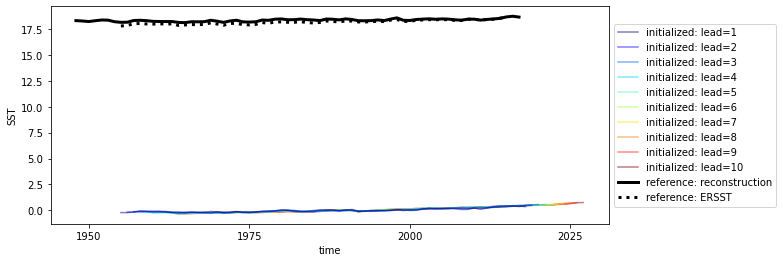

In [12]:
hindcast.plot()

We have a huge bias because the initialized data is already converted to an anomaly, but uninitialized historical and observations is not.

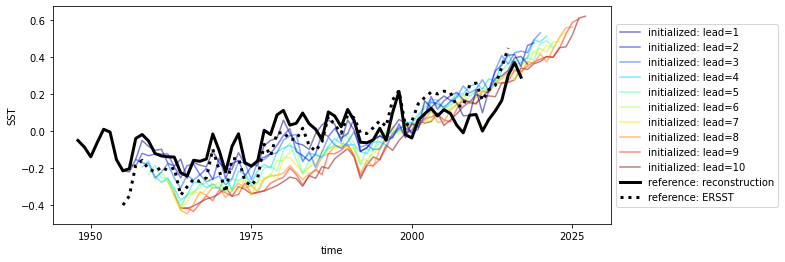

In [13]:
# always only subtract a PredictionEnsemble from another PredictionEnsemble if you handle time and init at the same time
hindcast = hindcast - hindcast.sel(time=slice('1964', '2014')).mean('time').sel(init=slice('1964', '2014')).mean('init')
hindcast.plot()

We still have a trend in all of our products, so we could also detrend them as well.

### Detrend

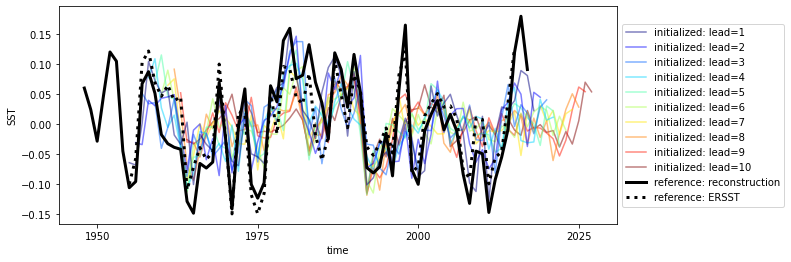

In [14]:
from climpred.stats import rm_poly
order=2
hindcast = hindcast.apply(rm_poly, dim='init', order=order).apply(rm_poly, dim='time', order=order)
hindcast.plot()

And it looks like everything got detrended by a linear fit! That wasn't too hard.

## Verify

Now that we've done our pre-processing, let's quickly compute some metrics. Check the metrics page [here](metrics.html) for all the keywords you can use. The [API](api.html#analysis-functions) is currently pretty simple for the `HindcastEnsemble`. You can essentially compute standard skill metrics and a reference persistence forecast.

If you just pass a metric, it'll compute the skill metric against all observations and return a dictionary with keys of the names the user entered when adding them.

In [15]:
hindcast.verify(metric='mse')

{'reconstruction': <xarray.Dataset>
 Dimensions:  (lead: 10, skill: 1)
 Coordinates:
   * lead     (lead) int64 1 2 3 4 5 6 7 8 9 10
   * skill    (skill) <U4 'init'
 Data variables:
     SST      (lead) float64 0.003499 0.005449 0.005848 ... 0.007232 0.008102,
 'ERSST': <xarray.Dataset>
 Dimensions:  (lead: 10, skill: 1)
 Coordinates:
   * lead     (lead) int64 1 2 3 4 5 6 7 8 9 10
   * skill    (skill) <U4 'init'
 Data variables:
     SST      (lead) float64 0.003457 0.004091 0.004623 ... 0.005327 0.005525}

One can also directly call individual observations to compare to. Here we leverage `xarray`'s plotting method to compute Mean Absolute Error and the Anomaly Correlation Coefficient for both our observational products, as well as the equivalent metrics computed for persistence forecasts for each of those metrics.

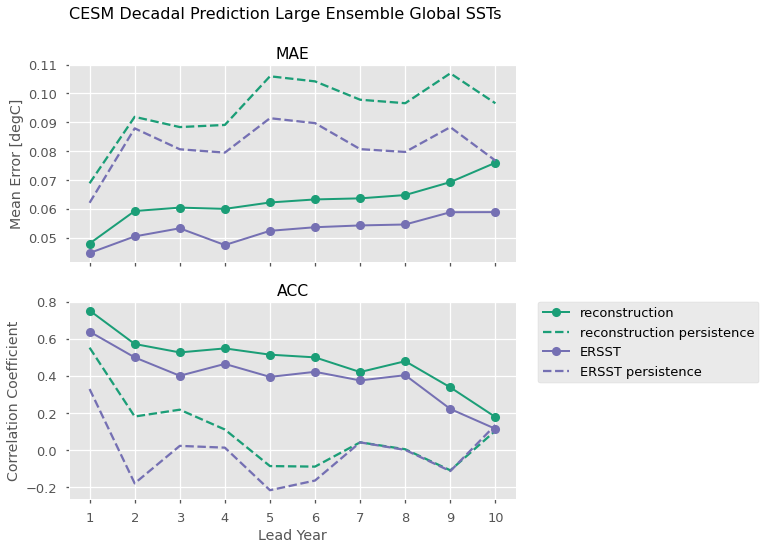

In [16]:
import numpy as np

plt.style.use('ggplot')
plt.style.use('seaborn-talk')

RECON_COLOR = '#1b9e77'
OBS_COLOR = '#7570b3'

f, axs = plt.subplots(nrows=2, figsize=(8, 8), sharex=True)

for ax, metric in zip(axs.ravel(), ['mae', 'acc']):
    handles = []
    for product, color in zip(['reconstruction', 'ERSST'], [RECON_COLOR, OBS_COLOR]):
        result = hindcast.verify(product, metric=metric, reference='persistence')
        p1, = result.sel(skill='init').SST.plot(ax=ax, 
                                       marker='o', 
                                       color=color,
                                       label=product,
                                       linewidth=2)
        p2, = result.sel(skill='persistence').SST.plot(ax=ax,
                                             color=color,
                                             linestyle='--',
                                             label=product + ' persistence')
        handles.append(p1)
        handles.append(p2)
    ax.set_title(metric.upper())
    

axs[0].set_ylabel('Mean Error [degC]')
axs[1].set_ylabel('Correlation Coefficient')
axs[0].set_xlabel('')
axs[1].set_xlabel('Lead Year')
axs[1].set_xticks(np.arange(10)+1)

# matplotlib/xarray returning weirdness for the legend handles.
handles = [i.get_label() for i in handles]

# a little trick to put the legend on the outside.
plt.legend(handles, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.suptitle('CESM Decadal Prediction Large Ensemble Global SSTs', fontsize=16)
plt.show()

## PerfectModelEnsemble

We'll now play around a bit with the `PerfectModelEnsemble` object, using sample data from the MPI perfect model configuration.

In [17]:
from climpred import PerfectModelEnsemble

In [18]:
ds = climpred.tutorial.load_dataset('MPI-PM-DP-1D') # initialized ensemble from MPI
control = climpred.tutorial.load_dataset('MPI-control-1D') # base control run that initialized it

In [19]:
ds["lead"].attrs["units"] = "years"

In [20]:
print(ds)

<xarray.Dataset>
Dimensions:  (area: 3, init: 12, lead: 20, member: 10, period: 5)
Coordinates:
  * lead     (lead) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20
  * period   (period) object 'DJF' 'JJA' 'MAM' 'SON' 'ym'
  * area     (area) object 'global' 'North_Atlantic' 'North_Atlantic_SPG'
  * init     (init) int64 3014 3023 3045 3061 3124 ... 3175 3178 3228 3237 3257
  * member   (member) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    tos      (period, lead, area, init, member) float32 ...
    sos      (period, lead, area, init, member) float32 ...
    AMO      (period, lead, area, init, member) float32 ...


In [21]:
pm = climpred.PerfectModelEnsemble(ds)
pm = pm.add_control(control)
print(pm)

/Users/aaron.spring/anaconda3/envs/climpred-dev/lib/python3.6/site-packages/climpred-2.0.0.post30+dirty-py3.6.egg/climpred/utils.py:141: UserWarning: Assuming annual resolution due to numeric inits. Change init to a datetime if it is another resolution.
  'Assuming annual resolution due to numeric inits. '


climpred.PerfectModelEnsemble

Show/Hide data repr 
 
 
 
 
 
 Show/Hide attributes 
 
 
 
 
 
 
 
 Initialized Ensemble Dimensions: area : 3 init : 12 lead : 20 member : 10 period : 5 Coordinates: (5) lead (lead) int64 1 2 3 4 5 6 7 ... 15 16 17 18 19 20 units : years array([ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
 19, 20]) period (period) object 'DJF' 'JJA' 'MAM' 'SON' 'ym' array(['DJF', 'JJA', 'MAM', 'SON', 'ym'], dtype=object) area (area) object 'global' ... 'North_Atlantic_SPG' array(['global', 'North_Atlantic', 'North_Atlantic_SPG'], dtype=object) init (init) object 3014-01-01 00:00:00 ... 3257-01-01 00:00:00 array([cftime.DatetimeProlepticGregorian(3014-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(3023-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(3045-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(3061-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(3124-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(3139-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(3144-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(3175-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(3178-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(3228-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(3237-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(3257-01-01 00:00:00)], dtype=object) member (member) int64 0 1 2 3 4 5 6 7 8 9 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]) Data variables: (3) tos (period, lead, area, init, member) float32 ... array([[[[[17.384073, ..., 17.389244],
 ...,
 [17.49527 , ..., 17.647034]],

 ...,

 [[ 7.004498, ..., 6.904807],
 ...,
 [ 7.15443 , ..., 6.934058]]],


 ...,


 [[[17.349993, ..., 17.345932],
 ...,
 [17.387072, ..., 17.506124]],

 ...,

 [[ 7.208045, ..., 6.726819],
 ...,
 [ 6.953272, ..., 7.062301]]]],



 ...,



 [[[[17.304762, ..., 17.2879 ],
 ...,
 [17.282705, ..., 17.358082]],

 ...,

 [[ 8.295001, ..., 8.414991],
 ...,
 [ 8.457472, ..., 8.715961]]],


 ...,


 [[[17.28034 , ..., 17.199175],
 ...,
 [17.197533, ..., 17.290545]],

 ...,

 [[ 9.117534, ..., 8.16558 ],
 ...,
 [ 8.585161, ..., 8.954581]]]]], dtype=float32) sos (period, lead, area, init, member) float32 ... array([[[[[34.381344, ..., 34.395466],
 ...,
 [34.379017, ..., 34.375397]],

 ...,

 [[34.621056, ..., 34.490482],
 ...,
 [34.73688 , ..., 34.667927]]],


 ...,


 [[[34.367462, ..., 34.3745 ],
 ...,
 [34.382206, ..., 34.3752 ]],

 ...,

 [[34.71535 , ..., 34.644875],
 ...,
 [34.60751 , ..., 34.749866]]]],



 ...,



 [[[[34.371273, ..., 34.377483],
 ...,
 [34.367928, ..., 34.367786]],

 ...,

 [[34.54275 , ..., 34.46146 ],
 ...,
 [34.542786, ..., 34.631397]]],


 ...,


 [[[34.360554, ..., 34.368996],
 ...,
 [34.37161 , ..., 34.35645 ]],

 ...,

 [[34.622524, ..., 34.52258 ],
 ...,
 [34.527443, ..., 34.587795]]]]], dtype=float32) AMO (period, lead, area, init, member) float32 ... array([[[[[ 0.167495, ..., 0.047088],
 ...,
 [-0.232761, ..., -0.273002]],

 ...,

 [[ 0.167495, ..., 0.047088],
 ...,
 [-0.232761, ..., -0.273002]]],


 ...,


 [[[ 0.273698, ..., -0.124981],
 ...,
 [-0.002182, ..., -0.01367 ]],

 ...,

 [[ 0.273698, ..., -0.124981],
 ...,
 [-0.002182, ..., -0.01367 ]]]],



 ...,



 [[[[ 0.072317, ..., 0.139705],
 ...,
 [-0.208696, ..., -0.327045]],

 ...,

 [[ 0.072317, ..., 0.139705],
 ...,
 [-0.208696, ..., -0.327045]]],


 ...,


 [[[ 0.325681, ..., -0.209799],
 ...,
 [-0.01501 , ..., 0.060747]],

 ...,

 [[ 0.325681, ..., -0.209799],
 ...,
 [-0.01501 , ..., 0.060747]]]]], dtype=float32) Attributes: (0)

Show/Hide data repr 
 
 
 
 
 
 Show/Hide attributes 
 
 
 
 
 
 
 
 Control Simulation Dimensions: area : 3 period : 5 time : 300 Coordinates: (3) time (time) object 3000-01-01 00:00:00 ... 3299-01-01 00:00:00 array([cftime.DatetimeProlepticGregorian(3000-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(3001-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(3002-01-01 00:00:00), ...,
 cftime.DatetimeProlepticGregorian(3297-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(3298-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(3299-01-01 00:00:00)], dtype=object) period (period) object 'DJF' 'JJA' 'MAM' 'SON' 'ym' array(['DJF', 'JJA', 'MAM', 'SON', 'ym'], dtype=object) area (area) object 'global' ... 'North_Atlantic_SPG' array(['global', 'North_Atlantic', 'North_Atlantic_SPG'], dtype=object) Data variables: (3) tos (period, time, area) float32 ... array([[[17.382196, 8.759807, 7.320567],
 [17.344793, 8.402126, 7.033539],
 ...,
 [17.406504, 8.515713, 6.448978],
 [17.368383, 8.417525, 6.937928]],

 [[17.159786, 13.499312, 10.919159],
 [17.00704 , 13.742612, 11.459312],
 ...,
 [17.085367, 13.076672, 9.879821],
 [17.125288, 13.465583, 10.465502]],

 ...,

 [[16.988144, 13.185364, 10.20008 ],
 [16.88766 , 13.153466, 9.775887],
 ...,
 [16.989845, 12.697525, 9.045184],
 [16.961275, 13.096062, 9.693774]],

 [[17.301888, 10.906495, 8.973052],
 [17.148916, 10.958404, 8.937663],
 ...,
 [17.221823, 10.586926, 7.862315],
 [17.232193, 10.836343, 8.346231]]], dtype=float32) sos (period, time, area) float32 ... array([[[34.371998, 33.502525, 34.719456],
 [34.355347, 33.519848, 34.671505],
 ...,
 [34.365993, 33.568325, 34.630814],
 [34.355545, 33.500748, 34.479523]],

 [[34.33216 , 33.232624, 34.601894],
 [34.330135, 33.188156, 34.487717],
 ...,
 [34.32915 , 33.16359 , 34.32454 ],
 [34.330036, 33.18352 , 34.319214]],

 ...,

 [[34.33014 , 33.288124, 34.564205],
 [34.326954, 33.26364 , 34.474926],
 ...,
 [34.320232, 33.2581 , 34.364594],
 [34.32564 , 33.225998, 34.278736]],

 [[34.357925, 33.449768, 34.69097 ],
 [34.355095, 33.3701 , 34.60008 ],
 ...,
 [34.35066 , 33.391457, 34.48565 ],
 [34.353535, 33.38208 , 34.451256]]], dtype=float32) AMO (period, time, area) float32 ... array([[[ 0.169961, 0.169961, 0.169961],
 [-0.103922, -0.103922, -0.103922],
 ...,
 [ 0.117817, 0.117817, 0.117817],
 [-0.032913, -0.032913, -0.032913]],

 [[ 0.234705, 0.234705, 0.234705],
 [ 0.267132, 0.267132, 0.267132],
 ...,
 [-0.13114 , -0.13114 , -0.13114 ],
 [ 0.036084, 0.036084, 0.036084]],

 ...,

 [[ 0.142128, 0.142128, 0.142128],
 [ 0.087876, 0.087876, 0.087876],
 ...,
 [-0.086413, -0.086413, -0.086413],
 [ 0.151093, 0.151093, 0.151093]],

 [[ 0.167775, 0.167775, 0.167775],
 [ 0.161447, 0.161447, 0.161447],
 ...,
 [-0.02503 , -0.02503 , -0.02503 ],
 [ 0.079047, 0.079047, 0.079047]]], dtype=float32) Attributes: (0)

Our objects are carrying sea surface temperature (`tos`), sea surface salinity (`sos`), and the Atlantic Multidecadal Oscillation index (`AMO`). Say we just want to look at skill metrics for temperature and salinity over the North Atlantic in JJA. We can just call a few easy `xarray` commands to filter down our object.

In [22]:
pm = pm.drop('AMO').sel(area='North_Atlantic', period='JJA')

Now we can easily compute for a host of metrics. Here I just show a number of deterministic skill metrics comparing all individual members to the initialized ensemble mean. See [comparisons](comparisons.html) for more information on the `comparison` keyword.

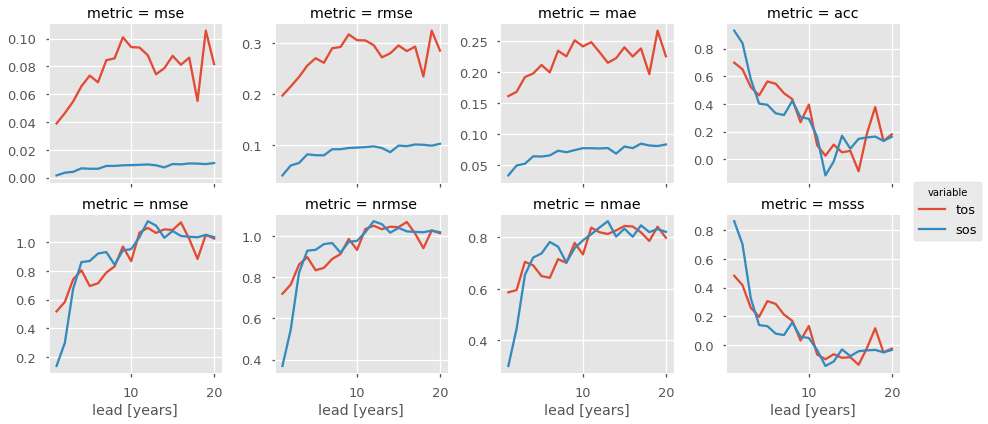

In [23]:
METRICS = ['mse', 'rmse', 'mae', 'acc',
           'nmse', 'nrmse', 'nmae', 'msss']

result = []
for metric in METRICS:
    result.append(pm.compute_metric(metric, comparison='m2e'))
    
result = xr.concat(result, 'metric')
result['metric'] = METRICS

# Leverage the `xarray` plotting wrapper to plot all results at once.
result.to_array().plot(col='metric', 
                       hue='variable', 
                       col_wrap=4, 
                       sharey=False, 
                       sharex=True)

It is useful to compare the initialized ensemble to an uninitialized run. See [terminology](terminology.html) for a description on "uninitialized" simulations. This gives us information about how *initializations* lead to enhanced predictability over knowledge of external forcing, whereas a comparison to persistence just tells us how well a dynamical forecast simulation does in comparison to a naive method. We can use the `generate_uninitialized()` method to bootstrap the control run and create a pseudo-ensemble that approximates what an uninitialized ensemble would look like.

In [24]:
pm = pm.generate_uninitialized()
print(pm)

climpred.PerfectModelEnsemble

Show/Hide data repr 
 
 
 
 
 
 Show/Hide attributes 
 
 
 
 
 
 
 
 Initialized Ensemble Dimensions: init : 12 lead : 20 member : 10 Coordinates: (5) lead (lead) int64 1 2 3 4 5 6 7 ... 15 16 17 18 19 20 units : years array([ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
 19, 20]) period () <U3 'JJA' array('JJA', dtype='<U3') area () <U14 'North_Atlantic' array('North_Atlantic', dtype='<U14') init (init) object 3014-01-01 00:00:00 ... 3257-01-01 00:00:00 array([cftime.DatetimeProlepticGregorian(3014-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(3023-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(3045-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(3061-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(3124-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(3139-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(3144-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(3175-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(3178-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(3228-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(3237-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(3257-01-01 00:00:00)], dtype=object) member (member) int64 0 1 2 3 4 5 6 7 8 9 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]) Data variables: (2) tos (lead, init, member) float32 13.464135 13.641711 ... 13.568891 array([[[13.464135, 13.641711, ..., 13.588738, 13.266194],
 [13.445477, 13.571556, ..., 13.525509, 13.063034],
 ...,
 [12.837116, 13.368766, ..., 12.992356, 12.98161 ],
 [12.917976, 13.191601, ..., 12.989105, 12.764714]],

 [[13.744945, 13.574756, ..., 13.699843, 13.458035],
 [13.599129, 13.605476, ..., 13.617603, 13.762051],
 ...,
 [12.549422, 13.148598, ..., 12.93991 , 12.665627],
 [13.0729 , 13.025772, ..., 13.134182, 13.14777 ]],

 ...,

 [[13.504623, 13.638802, ..., 13.734439, 13.001564],
 [13.149283, 13.082256, ..., 13.71314 , 13.515602],
 ...,
 [13.211761, 13.369294, ..., 12.697314, 13.112003],
 [13.114143, 13.344111, ..., 12.86262 , 13.52319 ]],

 [[13.923348, 13.569972, ..., 13.548902, 13.060498],
 [13.192071, 13.177944, ..., 13.212311, 13.26723 ],
 ...,
 [13.196457, 13.203984, ..., 12.743962, 12.803421],
 [13.555382, 13.436454, ..., 13.547691, 13.568891]]], dtype=float32) sos (lead, init, member) float32 33.183903 33.146976 ... 33.25843 array([[[33.183903, 33.146976, ..., 33.14601 , 33.09485 ],
 [33.169205, 33.154438, ..., 33.137466, 33.168583],
 ...,
 [32.995815, 32.983433, ..., 33.031227, 32.99914 ],
 [33.05064 , 33.114414, ..., 32.998016, 33.093204]],

 [[33.199635, 33.082794, ..., 33.234913, 33.11563 ],
 [33.144375, 33.187267, ..., 33.110977, 33.18133 ],
 ...,
 [33.081043, 33.05753 , ..., 33.098064, 32.96622 ],
 [33.104546, 33.033073, ..., 32.976826, 33.069054]],

 ...,

 [[33.174488, 33.30829 , ..., 33.105885, 32.935608],
 [33.13984 , 33.22768 , ..., 33.123425, 33.11398 ],
 ...,
 [33.17692 , 33.119602, ..., 32.99104 , 33.063793],
 [33.196835, 33.186802, ..., 33.227722, 33.400288]],

 [[33.136868, 33.354904, ..., 33.147465, 33.092255],
 [33.178905, 33.15257 , ..., 33.097546, 33.223183],
 ...,
 [32.995438, 33.067974, ..., 32.925762, 32.951527],
 [33.19941 , 33.20508 , ..., 33.18124 , 33.25843 ]]], dtype=float32) Attributes: (0)

Show/Hide data repr 
 
 
 
 
 
 Show/Hide attributes 
 
 
 
 
 
 
 
 Control Simulation Dimensions: time : 300 Coordinates: (3) time (time) object 3000-01-01 00:00:00 ... 3299-01-01 00:00:00 array([cftime.DatetimeProlepticGregorian(3000-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(3001-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(3002-01-01 00:00:00), ...,
 cftime.DatetimeProlepticGregorian(3297-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(3298-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(3299-01-01 00:00:00)], dtype=object) period () <U3 'JJA' array('JJA', dtype='<U3') area () <U14 'North_Atlantic' array('North_Atlantic', dtype='<U14') Data variables: (2) tos (time) float32 13.499312 13.742612 ... 13.465583 array([13.499312, 13.742612, 13.783769, ..., 12.917691, 13.076672, 13.465583],
 dtype=float32) sos (time) float32 33.232624 33.188156 ... 33.18352 array([33.232624, 33.188156, 33.201694, ..., 33.221058, 33.16359 , 33.18352 ],
 dtype=float32) Attributes: (0)

Show/Hide data repr 
 
 
 
 
 
 Show/Hide attributes 
 
 
 
 
 
 
 
 Uninitialized Dimensions: init : 12 lead : 20 member : 10 Coordinates: (5) period () <U3 'JJA' array('JJA', dtype='<U3') area () <U14 'North_Atlantic' array('North_Atlantic', dtype='<U14') lead (lead) int64 1 2 3 4 5 6 7 ... 15 16 17 18 19 20 units : years array([ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
 19, 20]) init (init) object 3014-01-01 00:00:00 ... 3257-01-01 00:00:00 array([cftime.DatetimeProlepticGregorian(3014-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(3023-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(3045-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(3061-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(3124-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(3139-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(3144-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(3175-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(3178-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(3228-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(3237-01-01 00:00:00),
 cftime.DatetimeProlepticGregorian(3257-01-01 00:00:00)], dtype=object) member (member) int64 0 1 2 3 4 5 6 7 8 9 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]) Data variables: (2) tos (lead, init, member) float32 13.563594 13.843094 ... 13.397359 array([[[13.563594 , 13.843094 , 13.516781 , ..., 13.510002 ,
 13.818301 , 13.142756 ],
 [13.240655 , 13.475286 , 13.232712 , ..., 13.945098 ,
 13.420995 , 13.33212 ],
 [13.952087 , 13.374789 , 13.644023 , ..., 13.720851 ,
 14.015565 , 13.669381 ],
 ...,
 [13.368962 , 13.105531 , 13.2029 , ..., 12.934174 ,
 13.128673 , 13.193572 ],
 [13.397359 , 13.149283 , 13.192071 , ..., 13.484596 ,
 13.290278 , 13.563594 ],
 [13.843094 , 13.516781 , 13.552386 , ..., 13.818301 ,
 13.142756 , 13.240655 ]],

 [[13.558215 , 13.905151 , 13.504623 , ..., 14.031241 ,
 13.446274 , 13.426196 ],
 [13.397359 , 13.149283 , 13.192071 , ..., 13.484596 ,
 13.290278 , 13.563594 ],
 [13.323382 , 12.982392 , 13.088628 , ..., 12.737117 ,
 12.959308 , 12.744426 ],
 ...,
 [13.03095 , 12.848511 , 12.844396 , ..., 13.313197 ,
 13.289608 , 13.121739 ],
 [13.361939 , 13.552769 , 13.545001 , ..., 13.454182 ,
 12.743481 , 13.122471 ],
 [13.021213 , 13.213646 , 13.301404 , ..., 13.972522 ,
 14.041756 , 13.789844 ]],

 [[13.196457 , 12.917976 , 13.0729 , ..., 13.355483 ,
 13.746189 , 13.501628 ],
 [13.477757 , 13.326875 , 13.210793 , ..., 12.733609 ,
 13.0328865, 13.114143 ],
 [13.211715 , 13.456677 , 13.323382 , ..., 12.875896 ,
 12.379665 , 12.737117 ],
 ...,
 [13.333903 , 13.415563 , 13.402343 , ..., 13.431491 ,
 13.209149 , 13.729543 ],
 [13.563594 , 13.843094 , 13.516781 , ..., 13.510002 ,
 13.818301 , 13.142756 ],
 [13.240655 , 13.475286 , 13.232712 , ..., 13.945098 ,
 13.420995 , 13.33212 ]],

 ...,

 [[13.326875 , 13.210793 , 13.175613 , ..., 13.0328865,
 13.114143 , 13.555382 ],
 [13.5077715, 13.165898 , 13.671746 , ..., 13.672458 ,
 12.787711 , 12.590709 ],
 [13.370372 , 13.702095 , 13.429088 , ..., 13.308548 ,
 13.46125 , 13.368962 ],
 ...,
 [13.741005 , 13.592628 , 12.733609 , ..., 13.165898 ,
 13.671746 , 13.50228 ],
 [13.672073 , 13.023871 , 13.40974 , ..., 13.009304 ,
 12.844365 , 12.837116 ],
 [12.549422 , 13.238998 , 12.791556 , ..., 13.067849 ,
 13.068427 , 13.627881 ]],

 [[13.0729 , 13.4815035, 13.82362 , ..., 13.501628 ,
 13.477757 , 13.326875 ],
 [13.210793 , 13.175613 , 13.463863 , ..., 13.114143 ,
 13.555382 , 13.5077715],
 [13.566142 , 13.720851 , 14.015565 , ..., 12.917198 ,
 13.200032 , 13.18824 ],
 ...,
 [13.302329 , 13.270309 , 13.202095 , ..., 13.543017 ,
 13.298736 , 13.49269 ],
 [13.113345 , 12.935954 , 13.188503 , ..., 13.349854 ,
 13.34776 , 13.729529 ],
 [13.242668 , 13.322024 , 13.333903 , ..., 13.511272 ,
 13.241531 , 13.431491 ]],

 [[13.117955 , 13.329198 , 13.066007 , ..., 13.444436 ,
 13.65182 , 13.37933 ],
 [13.543017 , 13.298736 , 13.49269 , ..., 13.161041 ,
 13.365125 , 13.58598 ],
 [13.1245575, 13.402501 , 1

In [25]:
pm = pm.drop('tos') # Just assess for salinity.

Here I plot the ACC for the initialized, uninitialized, and persistence forecasts for North Atlantic sea surface salinity in JJA. I add circles to the lines if the correlations are statistically significant for $p <= 0.05$.

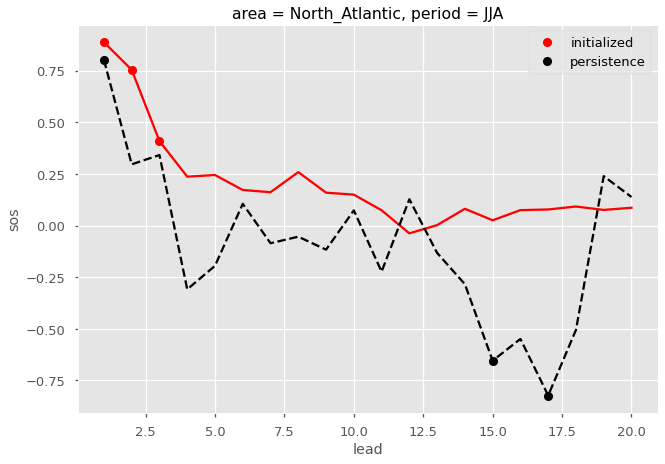

In [26]:
# ACC for initialized ensemble
acc = pm.compute_metric('acc')
acc.sos.plot(color='red')
acc.where(pm.compute_metric('p_pval') <= 0.05).sos.plot(marker='o', linestyle='None', color='red', label='initialized')

# ACC for 'uninitialized' ensemble
# acc = pm.compute_uninitialized('acc')
# acc.sos.plot(color='gray')
# acc.where(pm.compute_uninitialized('p_pval') <= 0.05).sos.plot(marker='o', linestyle='None', color='gray', label='uninitialized')

# ACC for persistence forecast
acc = pm.compute_persistence('acc')
acc.sos.plot(color='k', linestyle='--')
acc.where(pm.compute_persistence('p_pval') <= 0.05).sos.plot(marker='o', linestyle='None', color='k', label='persistence')

plt.legend()